#Análisis Factorial Exploratorio (AFE) y Confirmatorio (AFC) de variables procedentes de la Encuesta de Condiciones de Vida (ECV) con Python

## Librerías:

In [ ]:
import pandas as pd #Para el manejo de dataframes
import numpy as np #Para trabajar con arrays y para realizar operaciones matemáticas y estadísticas básicas
from sklearn.model_selection import train_test_split #Para llevar a cabo la división de la muestra en dos mitades mediante muestreo de las observaciones
#from scipy.stats import zscore #Para estandarizar las variables (media = 0, desviación típica = 1))

!pip install pingouin
#Esta libreria, a veces, da problemas al instalarla a la primera. Para solucionar el problema: debemos darle al botón "RESTART RUNTIME" que aparece; esperar a que se inicialice de nuevo el cuaderno, y volver a correr esta parte del script.
from pingouin import multivariate_normality #Para realizar el test de Henze-Zirkler (H-Z) de normalidad multivariante

import seaborn as sns #Para graficar la matriz de correlaciones
import matplotlib.pyplot as plt #Para realizar el gráfico de sedimentación

!pip install factor_analyzer
import factor_analyzer #Para realizar el Análisis Factorial Exploratorio (AFE)

!pip install semopy
import semopy #Para realizar el Análisis Factorial Confirmatorio (AFC)

## Datos:
Los datos que vamos a utilizar en este cuaderno proceden de la Encuesta de Condiciones de Vida (ECV) del año 2013. Dichos datos pueden descargarse de la siguiente página web:

https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=resultados&idp=1254735976608#!tabs-1254736195153

En concreto vamos a utilizar el Fichero P (fichero de datos detallados de los adultos (*esudb13p*)), para analizar la estructura factorial de la siguiente batería de preguntas relacionadas con el bienestar:

*¿Cuál es su grado de satisfacción global con...*


1. *... su vida en la actualidad?* (variable PW010).
2. *... la situación económica en su hogar?* (PW030).
4. *... su vivienda?* (PW040).
5. *... su trabajo actual?* (PW100).
6. *... el tiempo que dispone para hacer lo que le gusta?* (PW120).
11. *... sus relaciones personales?* (PW160).
12. *... las áreas recreativas o verdes de la zona en la que vive?* (PW200).
14. *... la calidad de la zona en la que vive?* (PW210).


En todos los casos la escala de respuesta va del 0 (*Nada satisfecho*) al 10 (*Plenamente satisfecho*).

In [2]:
from google.colab import files
uploaded = files.upload()

Saving esudb13p.csv to esudb13p.csv


In [3]:
datos=pd.read_csv("esudb13p.csv", delimiter=",", decimal=".", low_memory=False)
datos.head()

,PB010,PB020,PB030,PB040,PB040_F,PB100,PB100_F,PB110,PB110_F,PB120,PB120_F,PB130,PB130_F,PB140,PB140_F,PB150,PB150_F,PB160,PB160_F,PB170,PB170_F,PB180,PB180_F,PB190,PB190_F,PB200,PB200_F,PB210,PB210_F,PB220A,PB220A_F,PE010,PE010_F,PE020,PE020_F,PE030,PE030_F,PE040,PE040_F,PL031,...,PW100,PW100_F,PW110,PW110_F,PW120,PW120_F,PW130,PW130_F,PW140,PW140_F,PW150,PW150_F,PW160,PW160_F,PW170,PW170_F,PW180,PW180_F,PW190,PW190_F,PW200,PW200_F,PW210,PW210_F,PW220,PW220_F,PD020,PD020_F,PD030,PD030_F,PD050,PD050_F,PD060,PD060_F,PD070,PD070_F,PD080,PD080_F,PD090,PD090_F
0,2013,ES,101,1525.77214,1,6,1,2013,1,33,1,9,1,1964,1,2,1,,-2,,-2,103,1,2,1,1,1,1,1,1,1,1,1,5,1,1989,1,5,1,1,...,8,1,8,1,8,1,4,1,4,1,5,1,8,1,1,1,1,1,7,1,8,1,8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1
1,2013,ES,102,1525.77214,1,6,1,2013,1,33,1,9,1,1993,1,2,1,103,1,101,1,,-2,1,1,3,1,1,1,1,1,1,1,5,1,2011,1,3,1,6,...,,-2,,-2,8,1,5,1,5,1,5,1,8,1,1,1,1,1,7,1,8,1,8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2013,ES,103,1525.77214,1,6,1,2013,1,26,1,5,1,1961,1,1,1,,-2,,-2,101,1,2,1,1,1,1,1,1,1,2,1,,-2,1979,1,5,1,1,...,7,1,7,1,5,1,2,1,2,1,5,1,7,1,1,1,1,1,5,1,7,1,7,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,6,1
3,2013,ES,201,913.04718,1,6,1,2013,1,,-1,4,1,1979,1,1,1,,-2,,-2,202,1,1,1,2,1,1,1,1,1,2,1,,-2,1996,1,2,1,3,...,10,1,10,1,10,1,0,1,0,1,0,1,10,1,1,1,1,1,3,1,5,1,5,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,5,1
4,2013,ES,202,883.50422,1,6,1,2013,1,23,1,8,1,1979,1,2,1,,-2,,-2,201,1,1,1,2,1,1,1,1,1,2,1,,-2,1998,1,5,1,2,...,9,1,10,1,6,1,0,1,0,1,0,1,10,1,1,1,1,1,8,1,8,1,8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,5,1


In [4]:
#PB030 identificador único de la persona
datos = datos[["PB030", "PW010", "PW030", "PW040", "PW100", "PW120", "PW160", "PW200", "PW210"]]
datos.dtypes #Vemos que las columnas son de tipo object

PB030     int64
PW010    object
PW030    object
PW040    object
PW100    object
PW120    object
PW160    object
PW200    object
PW210    object
dtype: object

In [5]:
#Lo convertimos a tipo numerico, para poder llevar a cabo los análisis
datos = datos.apply(pd.to_numeric, errors="coerce") # errors="coerce" para que no den problemas los datos perdidos
datos.head()

,PB030,PW010,PW030,PW040,PW100,PW120,PW160,PW200,PW210
0,101,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
1,102,8.0,8.0,8.0,NaN,8.0,8.0,8.0,8.0
2,103,7.0,7.0,7.0,7.0,5.0,7.0,7.0,7.0
3,201,10.0,4.0,8.0,10.0,10.0,10.0,5.0,5.0
4,202,10.0,4.0,7.0,9.0,6.0,10.0,8.0,8.0


Como vamos a hacer un doble Análisis Factorial - Exploratorio y Confirmatorio - vamos a dividir la muestra en aproximadamente el 50%, realizando el Exploratorio sobre una mitad, y el Confirmatorio sobre la otra, para ver si los resultados concuerdan.

In [6]:
np.random.seed(1000) #Establecemos una semilla para facilitar la reproductibilidad de los resultados
datos = datos.dropna() #Quitamos las observaciones con perdidos, ya que nos van a dar problemas a la hora de computar los análisis
datos_AFE, datos_AFC = train_test_split(datos, test_size = 0.5)
print(len(datos_AFE.index)) #5132 observaciones
print(len(datos_AFC.index)) #5132 observaciones
#Eliminamos la columna de IDs, ya que no nos hace falta:
datos_AFE = datos_AFE.drop(["PB030"], axis=1) 
datos_AFC = datos_AFC.drop(["PB030"], axis=1)

5132
5132


## Análisis Factorial Exploratorio (AFE):
El Análisis Factorial Exploratorio (AFE) es un método para reducir la dimensionalidad de un conjunto de variables/indicadores, es decir, es un método para resumir la información. En este sentido, puede confundirse con el Análisis de Componentes Principales (ACP).

El ACP parte de la varianza total para encontrar combinaciones lineales entre las variables originales que expliquen la mayor parte de dicha varianza total. Así, el primer componente principal sería aquella combinación lineal de variables que explica un mayor porcentaje de varianza total; el segundo componente principal sería aquel que explica la mayor proporción de varianza no explicada por el primero, y así sucesivamente. Al aplicar ACP a un conjunto de datos conseguimos pues resumir la información en unas pocas componentes principales. Dichas componentes principales, al ser combinaciones lineales de variables, resultan, muchas veces, difíciles de interpretar.

Por su parte, el AFE distingue entre varianza común y varianza específica. La varianza común o compartida es aquella parte de la variabilidad total de los datos que está compartida entre las variables; mientras, la varianza no compartida es la específica de cada variable. Los factores comunes son, por tanto, variables subyacentes - no observadas - que explican la asociación entre las variables.

Asimismo, desde el punto de vista de las variables, decimos que la comunalidad de una variable es la parte de su varianza explicada por los factores comunes. Por ello, interesa que este dato sea alto. Por el contrario, la especificidad es la parte de variabilidad de una variable específica de dicha variable. Esta última conviene pues que sea baja.

Los factores sí suelen tener una interpretación más sencilla que los componentes principales. Asimismo, mientras los componentes principales, por definición, no están correlacionados, los factores pueden estarlo.

El AFE suele utilizarse con datos procendentes de encuestas sociales, psicológicas o sanitarias, sin embargo, también puede aplicarse a otros tipos de datos. En nuestro caso tenemos datos procedentes de una encuesta de carácter sociodemográfico.

###Paso 1: Estimación de la matriz de correlaciones.
Dependiendo del tipo de datos que tengamos, debemos utilizar un tipo de correlación u otro:
* Datos continuos: La matriz de correlaciones de Pearson y la de Spearman son las más apropiadas ante continuos o ante datos ordinales (categóricos) con más de 7 categorías de respuesta (tienden a la continuidad).
* Datos categóricos/ordinales: la matriz de correlaciones policórica es la más recomendada ante datos ordinales de 7 o menos categorías de respuesta. Si tuviéramos datos dicotómicos, la matriz a emplear sería la matriz tetracórica (similar a la policórica pero con datos dicotómicos).

En nuestro caso, como tenemos datos ordinales con 11 opciones de respuesta (del 0 al 10), usaremos la matriz de correlaciones de Pearson.

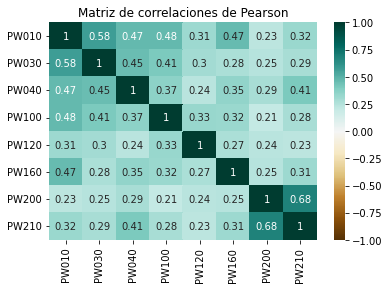

In [7]:
matriz_correlaciones = datos_AFE.corr()
heatmap = sns.heatmap(matriz_correlaciones, vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title("Matriz de correlaciones de Pearson");

Todas las correlaciones son positivas y, en general, no son muy altas.

### Paso 2: Verificar que la matriz sea factorizable (es decir, que tiene sentido hacer un AFE con nuestros datos):
(Si la matriz no fuese factorizable, la relación entre las variables sería tan baja que no se formarían factores).

Entre los métodos para comprobar si la matriz es factorizable destacan:
* Test de esfericidad de Bartlett: se pregunta si la matriz de correlaciones es o no la matriz identidad. Si la matriz de correlaciones es la matriz identidad, las variables no estarían correlacionadas y no habría varianza compartida de la que extraer los factores (no habría factores comunes). Si rechazamos la hipótesis nula (la matriz de correlaciones es la matriz identidad), la matriz será factorizable.
* Medida KMO (Kaiser-Meyer-Olkin): expresa el grado de predicción de las variables a partir de las demás. Su valor oscila entre 0 y 1. Cuanto mayor sea, mejor. Valores a partir de 0,5 se consideran aceptables.
* Calcular el determinante de la matriz de correlaciones: valores cercanos a cero indican que la matriz es factorizable.

In [8]:
print("El resultado del test de esfericidad de Bartlett es:")
factor_analyzer.factor_analyzer.calculate_bartlett_sphericity(datos_AFE)

El resultado del test de esfericidad de Bartlett es:


(12339.125918919142, 0.0)

In [9]:
print("La medida KMO es:")
factor_analyzer.factor_analyzer.calculate_kmo(datos_AFE)

La medida KMO es:


(array([0.8043866 , 0.82035637, 0.88190034, 0.88865534, 0.89160392,
        0.85851728, 0.66600226, 0.69887353]), 0.7998034102389066)

In [10]:
print("El determinante de la matriz es:")
np.linalg.det(matriz_correlaciones)

El determinante de la matriz es:


0.09027439224068196

1. El p-valor (0) es menor a los niveles de significación habituales(10%, 5% y 1%) por lo que rechazamos la hipótesis nula: la matriz de correlaciones no es la matriz identidad.
2. El resultado del KMO es bueno: aproximadamente 0,8.
3. El determinante tiene un valor bastante bajo.

Los test muestran que la matriz es factorizable.

### Paso 3: determinar un método de extracción de factores:
La ecuación del modelo factorial es la siguiente:

\begin{align}
X_j = a_{j1}F_1 + a_{j2}F_2
+ ... +a_{jn}F_n + u_j
\end{align}

Donde $X_j$ (variable j) es una combinación lineal de factores comunes y del factor único (especificidad). Los $a_{jh}$ son los pesos factoriales, que representan la importancia que cada factor común tiene en explicar la variable $X_j$.

El objetivo de los métodos de extracción de factores es reproducir, con el mínimo error, la matriz de correlaciones a partir de la matriz de pesos factoriales.

Existen varios métodos de extracción de factores. Los más comunes son:
*   Máxima Verosimilitud (*Maximum Likelihood*, ML). Para utilizarlo, nuestros datos deben seguir una normal multivariante (lo que podemos comprobar realizando el test de Mardia o el de Henze-Zirkler, por ejemplo). Estadísticamente es el más adecuado, pues es asintóticamente insesgado, eficiente y consistente.
*   Mínimos Cuadrados No Ponderados (*Unweighted Least Squares*, ULS) (También llamado Residuos Mínimos, MinRes). No requiere de la existencia de normalidad multivariante.
* Ejes principales. Tampoco requiere de datos que sigan una normal multivariante.
* Componentes principales. Como hemos dicho en la introducción, no es método de ánalisis factorial propiamente dicho, ya que su objetivo es intentar explicar toda la varianza, y no solo la varianza común o compartida. Sin embargo, su uso, aunque no se recomiende, está bastante extendido, pues es la opción por defecto de muchos programas estadísticos.

In [11]:
#Test Henze-Zirkler de normalidad multivariante:
multivariate_normality(datos_AFE, alpha=.05)

HZResults(hz=17.427514620739633, pval=0.0, normal=False)

Como el p-valor es inferior a los niveles de significación habituales (10%, 5% y 1%) se rechaza la hipótesis nula, es decir, se rechaza la normalidad de los datos.

Como no existe normalidad, debemos emplear un método de extracción de factores robusto la inexistencia de la misma, como es ULS/MinRes (Mínimos Cuadrados No Ponderados).

### Paso 4: Determinamos el número de factores a extraer:
Existen cuatro métodos principales:
* Regla de Kaiser: se deben aceptar todos aquellos factores con un autovalor mayor a 1.
* Gráfico de sedimentación (*scree plot*): gráfico donde podemos ver cómo disminuye la varianza explicada o el autovalor a medida que vamos aumentando el número de factores a extraer. Se complementa muy bien con la regla de Kaiser. 
* Establecimiento de un porcentaje de varianza explicada mínimo (por ejemplo, el 75%): cogeríamos todos los factores necesarios para explicar ese porcentaje mínimo de varianza.
* Análisis paralelo (AP, método recomendado): el AP parte de generar nuevas muestras aleatorias (mínimo 100) con el mismo número de variables y observaciones que la muestra original y, a partir de ello, se queda con aquellos factores cuyo autovalor es superior a los generados por azar. 

Emplearemos el Análisis Paralelo al ser el método más recomendado. En Python no existe a día de hoy una librería para llevar a cabo el análisis paralelo de forma sencilla, pero utilizaremos una adaptación de la siguiente función que lo implementa:
https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python

In [16]:
def Analisis_Paralelo(datos, numero_muestras_aleatorias, metodo_extraccion_factores):
    ################
    # Creamos una matriz con valores simulados
    ################
    n, m = datos.shape
    fa = factor_analyzer.FactorAnalyzer(n_factors=1, method=metodo_extraccion_factores, rotation=None, use_smc=True)
    Suma_Autovalores = np.empty(m)
    for runNum in range(0, numero_muestras_aleatorias):
        fa.fit(np.random.normal(size=(n, m)))
        Suma_Autovalores = Suma_Autovalores + fa.get_eigenvalues()[1]
    # Obtenemos los autovalores medios obtenidos a partir de los datos simulados
    Autovalores_medios_simulados = Suma_Autovalores / numero_muestras_aleatorias

    ################
    # Obtenemos los autovalores para los datos reales
    ################
    fa.fit(datos)
    Autovalores_reales = fa.get_eigenvalues()

    ################
    # Graficamos los resultados
    ################
    plt.figure(figsize=(8, 6))
    Factores_sugeridos = sum((Autovalores_reales[1] - Autovalores_medios_simulados) > 0)
    print("El Análisis Parelelo recomienda la extracción de" , Factores_sugeridos, "factores")
    plt.plot([0, m+1], [1, 1], "k--", alpha=0.3) # Regla de Kaiser
    # Datos simulados:
    plt.plot(range(1, m+1), Autovalores_medios_simulados, 'g', label="Datos simulados", alpha=0.4)
    # Datos reales:
    plt.scatter(range(1, m+1), Autovalores_reales[1], c='g', marker='o')
    plt.plot(range(1, m+1), Autovalores_reales[1], 'g', label="Datos reales")
    plt.title("Análisis Paralelo", {"fontsize": 20})
    plt.xlabel("Número de factores", {"fontsize": 15})
    plt.xticks(ticks=range(1, m+1), labels=range(1, m+1))
    plt.ylabel("Autovalores", {"fontsize": 15})
    plt.legend()
    plt.show();

El Análisis Parelelo recomienda la extracción de 4 factores


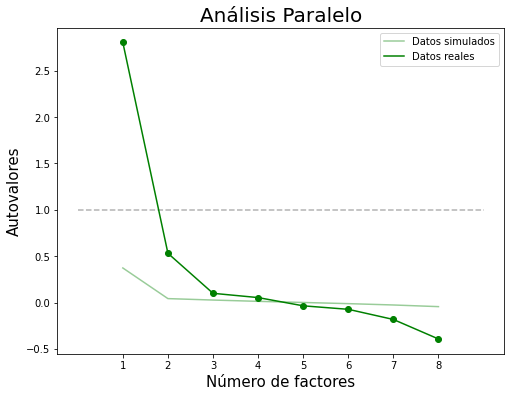

In [17]:
Analisis_Paralelo(datos=datos_AFE, numero_muestras_aleatorias=500, metodo_extraccion_factores="minres")

El Análisis Paralelo sugiere la extracción de 4 factores.

### Extracción de factores:
Vamos a extraer cuatro factores, siguiendo el Análisis Paralelo.

Asimismo, debemos decidir si vamos a rotar los factores y qué tipo de rotación vamos a emplear. Los métodos de rotación facilitan la interpretación de los factores, ya que sin rotarlos, suele ser muy difíciles de interpretar, por lo que se recomienda el uso de dichas técnicas de rotación.

Existen dos tipos de rotación:
* Rotación oblicua: permite que los factores puedan tener correlación entre ellos. Tipo recomendado, ya que es el más cercano a la estructura real que deseamos explorar. Un ejemplo es el método *oblimin*.
* Rotación ortogonal: fuerza a los factores a que no puedan tener correlación entre ellos. Un ejemplo es el método *varimax*.

Probaremos los dos y nos quedaremos con la solución que mejor resultado arroje. Pero, ¿cómo determinamos qué solución factorial ajusta mejor?
* Fijándonos en los pesos factoriales: Cuanto mayor sea el peso factorial de un ítem en un factor mejor. Se aceptan pesos factoriales por encima de 0,4. En general, una buena solución presentará variables que pesan mucho en un factor y poco en el resto.
* Índices de bondad del ajuste. Existen unos cuantos, pero nos podemos fijar en RMSEA, SRMR, TLI y CFI. RMSEA y SRMR cuantos más bajos mejor (se aceptan valores por debajo de 0,08), y TLI y CFI cuantos más altos mejor (valores por encima de 0,95 se consideran muy buenos). Desgraciadamente, esta librería de Python, no cuenta con funciones para estimar dichos índices de ajuste.

In [ ]:
#Con rotación oblicua oblimin:
fa_oblimin = factor_analyzer.FactorAnalyzer(rotation="oblimin", method='minres', n_factors=4);
fa_oblimin.fit(datos_AFE);
pd.DataFrame(fa_oblimin.loadings_, columns=["Factor1", "Factor2", "Factor3", "Factor4"], index=[datos_AFE.columns])

,Factor1,Factor2,Factor3,Factor4
PW010,-0.052391,0.797296,0.081962,-0.017260
PW030,0.009250,0.013713,0.983926,0.007917
PW040,0.179428,0.450368,0.116333,-0.021522
PW100,0.025047,0.484841,0.059268,0.112656
PW120,-0.000862,0.002843,0.003725,0.995586
PW160,0.084634,0.619323,-0.159851,0.051068
PW200,0.685678,-0.035966,0.040352,0.069265
PW210,0.983206,0.014216,-0.006048,-0.021650


In [ ]:
pd.DataFrame(fa_oblimin.get_factor_variance(), columns=["Factor1", "Factor2", "Factor3", "Factor4"], index=["Varianza de cada factor", "Proporción de varianza explicada", "Varianza acumulada"])

,Factor1,Factor2,Factor3,Factor4
Varianza de cada factor,1.479664,1.458837,1.019105,1.012581
Proporción de varianza explicada,0.184958,0.182355,0.127388,0.126573
Varianza acumulada,0.184958,0.367313,0.494701,0.621273


1. Vemos que los ítems que más pesan en el factor 1 son PW200 y PW210.
2. Los ítems que más pesan en el factor 2 son PW010, PW040, PW100 y PW160.
3. El ítem que más pesa en el factor 3 es PW030.
4. Y el ítem que más pesa en el factor 4 es PW120.

Los pesos factoriales son, en general, bastante buenos, ya que, para cada variable, son muy altos en un solo factor, y bajos en el resto.

El total de varianza explicada por los cuatro factores es del 62,13%. No es demasiado alto, pero tampoco es nada desdeñable.

In [ ]:
#Con rotación ortogonal varimax:
fa_varimax = factor_analyzer.FactorAnalyzer(rotation="varimax", method='minres', n_factors=4);
fa_varimax.fit(datos_AFE);
pd.DataFrame(fa_varimax.loadings_, columns=["Factor1", "Factor2", "Factor3", "Factor4"], index=[datos_AFE.columns])

,Factor1,Factor2,Factor3,Factor4
PW010,0.758286,0.110493,0.283568,0.095783
PW030,0.384350,0.128959,0.904779,0.111566
PW040,0.503637,0.270555,0.239617,0.063685
PW100,0.507679,0.138589,0.197378,0.181052
PW120,0.237517,0.125222,0.099642,0.955600
PW160,0.551826,0.188202,0.032010,0.121361
PW200,0.168040,0.667011,0.088108,0.110517
PW210,0.250151,0.946342,0.073992,0.044706


In [ ]:
pd.DataFrame(fa_varimax.get_factor_variance(), columns=["Factor1", "Factor2", "Factor3", "Factor4"], index=["Varianza de cada factor", "Proporción de varianza explicada", "Varianza acumulada"])

,Factor1,Factor2,Factor3,Factor4
Varianza de cada factor,1.685849,1.512813,1.019601,1.000570
Proporción de varianza explicada,0.210731,0.189102,0.127450,0.125071
Varianza acumulada,0.210731,0.399833,0.527283,0.652354


Los resultados son casi idénticos al usar el metodo de rotación ortogonal. Simplemente, en este caso, los ítems que más pesaban en el factor 1 con rotación oblicua, son los que más pesan ahora en el factor 2, y viceversa. Además, en este caso, el porcentaje de varianza explicada total es ligeramente mayor (65,24%).

### Resultados AFE:
El resultado usando tanto la rotación oblicua como la ortogonal es similar: la estructura en cuatro factores parece nítida.

## Análisis Factorial Confirmatorio (AFC):
La diferencia fundamental entre el AFE y el AFC, es que el AFE, como su propio nombre indica, es una técnica exploratoria: con ella queremos conocer la estructura de factores o variables latentes subyacente a los datos. Sin embargo, con el AFC, nosotros testamos si una determinada estructura factorial ajusta bien o no a los datos. Esto es, en este segundo caso, nosotros debemos imponer una estructura fatorial de antemano. Recurriendo a los índices de bondad del ajusto comprobaremos si dicha estructura es o no correcta.


### Paso 1: determinar un método de extracción de factores:
Al igual que hacíamos con el AFE, con el AFC también debemos determinar un método concreto para extraer los factores. Con el fin de establecer un método u otro, llevaremos a cabo un test de Henze-Zirkler: si existiera normalidad multivariante, podríamos utilizar Máxima Verosimilitud. Si nuestros datos no fuesen normales, Mínimo Cuadrados No Ponderados sería, de nuevo, una buena opción.

In [ ]:
#Test Henze-Zirkler de normalidad multivariante:
multivariate_normality(datos_AFC, alpha=.05)

HZResults(hz=15.706240119131383, pval=0.0, normal=False)

Como podíamos esperar los resultados son idénticos a los obtenidos con la mitad de la muestra destinada al AFE: rechazamos la hipótesis nula de normalidad multivariante (al ser el p-valor inferior a los niveles de significación habituales). Por ello, tampoco podemos usar Máxima Verosimilitud para el AFC, y usaremos, de nuevo, Mínimos Cuadrados No Ponderados (ULS/MinRes).

### Paso 2: Probar una o varias estructuras factoriales:
Vamos a plantear 3 modelos diferentes: uno que replique la estructura factorial planteada en el AFE, otro de un solo factor y otro de dos factores.

Para comparar modelos nos vamos a fijar en los índices de bondad del ajuste. Al igual que comentamos con el AFE: la situación óptima es aquella en la que los índices RMSEA es inferior a 0,08 - cuanto más bajos mejor -, y los índices TLI y CFI son superiores a 0,95 - cuanto más altos mejor.

### Modelo con los cuatro factores que muestra el Exploratorio:

In [ ]:
#Especificamos el modelo:
mod_4F = """
           Factor1 =~ PW010 + PW040 + PW100 + PW160
           Factor2 =~ PW200 + PW210
           Factor3 =~ PW030
           Factor4 =~ PW120
           """
modelo4F = semopy.Model(mod_4F)
#Realizamos el factorial:
factorial_4F = modelo4F.fit(datos_AFC, obj="ULS")
modelo4F.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,PW010,~,Factor1,1.000000,-,-,-
1,PW040,~,Factor1,0.974981,0.0230086,42.3746,0
2,PW100,~,Factor1,1.043738,0.0264166,39.5107,0
3,PW160,~,Factor1,0.767571,0.0210089,36.5354,0
4,PW200,~,Factor2,1.000000,-,-,-
5,PW210,~,Factor2,0.966813,0.0294508,32.8281,0
6,PW030,~,Factor3,1.000000,-,-,-
7,PW120,~,Factor4,1.000000,-,-,-
8,Factor2,~~,Factor2,2.867505,0.120504,23.796,0
9,Factor2,~~,Factor3,1.027942,0.0581845,17.6669,0


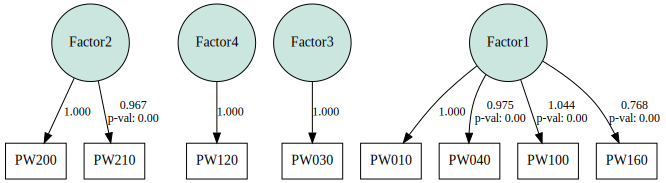

In [ ]:
#Creamos un gráfico SEM:
semopy.semplot(modelo4F, "modelo4F.pdf")

In [ ]:
#Índices de bondad del ajuste:
print("El valor del índice CFI es:")
print(semopy.calc_stats(modelo4F)["CFI"])
print("El valor del índice TLI es:")
print(semopy.calc_stats(modelo4F)["TLI"])
print("El valor del índice RMSEA es:")
print(semopy.calc_stats(modelo4F)["RMSEA"])

El valor del índice CFI es:
Value    0.986713
Name: CFI, dtype: float64
El valor del índice TLI es:
Value    0.973426
Name: TLI, dtype: float64
El valor del índice RMSEA es:
Value    0.303999
Name: RMSEA, dtype: float64


Se nos despliega una gran cantidad de información, pero, para facilitar el análisis, nos fijaremos simplemente en los índices de bondad del ajuste: TLI y CFI presentan unos valores muy buenos (mayores a 0,95). Sin embargo, RMSEA es claramente mayor a 0,08.

### Modelo con un solo factor:

In [ ]:
#Especificamos el modelo:
mod_1F = """
         Factor =~ PW010 + PW040 + PW100 + PW160 + PW200 + PW210 + PW030 + PW120
         """
modelo1F = semopy.Model(mod_1F)
#Realizamos el factorial:
factorial_1F = modelo1F.fit(datos_AFC, obj="ULS")
modelo1F.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,PW010,~,Factor,1.000000,-,-,-
1,PW040,~,Factor,1.009728,0.025437,39.6952,0
2,PW100,~,Factor,1.054617,0.0289694,36.4045,0
3,PW160,~,Factor,0.792280,0.0230135,34.4267,0
4,PW200,~,Factor,1.004641,0.0325813,30.8349,0
5,PW210,~,Factor,0.986899,0.0268935,36.6966,0
6,PW030,~,Factor,1.077645,0.0293446,36.7238,0
7,PW120,~,Factor,1.041495,0.0336353,30.9643,0
8,Factor,~~,Factor,1.267572,0.0510804,24.8152,0
9,PW200,~~,PW200,3.836091,0.0817413,46.9297,0


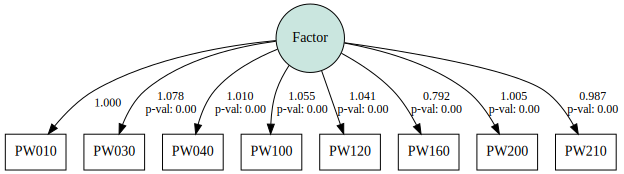

In [ ]:
#Creamos un gráfico SEM:
semopy.semplot(modelo1F, "modelo1F.pdf")

In [ ]:
#Índices de bondad del ajuste:
print("El valor del índice CFI es:")
print(semopy.calc_stats(modelo1F)["CFI"])
print("El valor del índice TLI es:")
print(semopy.calc_stats(modelo1F)["TLI"])
print("El valor del índice RMSEA es:")
print(semopy.calc_stats(modelo1F)["RMSEA"])

El valor del índice CFI es:
Value    0.918588
Name: CFI, dtype: float64
El valor del índice TLI es:
Value    0.886024
Name: TLI, dtype: float64
El valor del índice RMSEA es:
Value    0.629576
Name: RMSEA, dtype: float64


CFI, TLI y RMSEA presentan todos peores valores que en el modelo de 4 factores.

### Modelo con dos factores:
Planteamos un modelo con dos factores: uno que englobe los tres items relacionados con la vivienda, y otro que englobe el resto de ítems.

In [ ]:
#Planteamos el modelo:
mod_2F = """
            factor_vivienda =~ PW040 + PW200 + PW210
            factor_miscelanea =~ PW010 + PW030 + PW100 + PW120 + PW160
            """
modelo2F = semopy.Model(mod_2F)
#Realizamos el factorial:
factorial_2F = modelo2F.fit(datos_AFC, obj="ULS")
modelo2F.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,PW040,~,factor_vivienda,1.000000,-,-,-
1,PW200,~,factor_vivienda,1.157625,0.0314394,36.8208,0
2,PW210,~,factor_vivienda,1.144987,0.0279072,41.0284,0
3,PW010,~,factor_miscelanea,1.000000,-,-,-
4,PW030,~,factor_miscelanea,1.068572,0.0277677,38.4825,0
5,PW100,~,factor_miscelanea,1.051856,0.0274331,38.3426,0
6,PW120,~,factor_miscelanea,1.033000,0.0317944,32.49,0
7,PW160,~,factor_miscelanea,0.775211,0.0217081,35.7107,0
8,factor_vivienda,~~,factor_vivienda,1.478181,0.0574686,25.7216,0
9,factor_vivienda,~~,factor_miscelanea,0.971999,0.0356443,27.2694,0


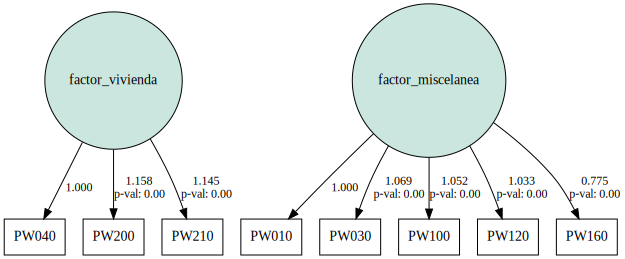

In [ ]:
#Creamos un gráfico SEM:
semopy.semplot(modelo2F, "modelo2F.pdf")

In [ ]:
#Índices de bondad del ajuste:
print("El valor del índice CFI es:")
print(semopy.calc_stats(modelo2F)["CFI"])
print("El valor del índice TLI es:")
print(semopy.calc_stats(modelo2F)["TLI"])
print("El valor del índice RMSEA es:")
print(semopy.calc_stats(modelo2F)["RMSEA"])

El valor del índice CFI es:
Value    0.949829
Name: CFI, dtype: float64
El valor del índice TLI es:
Value    0.926064
Name: TLI, dtype: float64
El valor del índice RMSEA es:
Value    0.50707
Name: RMSEA, dtype: float64


CFI, TLI y RMSEA mejoran con respecto al modelo de un factor, pero no lo suficiente.

### Resultados AFC:
Los índices de bondad del ajuste muestran que, de los tres modelos planteados, el modelo que refleja la estructura de los cuatro factores del AFE es el que mejor ajuste tiene.

## Paso final Análisis Factorial: Interpretamos los factores obtenidos tanto con el AFE como con el AFC:
Intentamos darle nombre a los factores, facilitando la interpretación de los resultados.

Los resultados entre el Análisis Factorial Exploratorio (AFE) y el Confirmatorio (AFC) concuerdan: el modelo que mejor ajusta es el que tiene cuatro factores:

* Factor 1: variables PW010 (grado de satisfacción con la vida en la actualidad), PW040 (grado de satisfacción con la vivienda), PW100 (grado de satisfacción con el trabajo actual) y PW160 (grado de satisfacción con las relaciones personales). Factor "bienestar general/principal".
* Factor 2: variables PW200 (grado de satisfacción con las áreas recreativas o verdes de la zona en la que vive) y PW210 (grado de satisfacción con la calidad de la zona en la que vive).  Factor "zona residencial".
* Factor 3: variable PW030 (grado de satisfacción con la situación económica en su hogar). Factor "situación económica".
* Factor 4: variable PW120 (grado de satisfacción con el tiempo que dispone para hacer lo que le gusta). Factor "tiempo libre".